In [56]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import scipy
import sklearn
import re
import sys
import random
# 方差
from sklearn.feature_selection import VarianceThreshold
# 相关性过滤
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# 皮尔逊相关系数
from scipy.stats import pearsonr
from collections import OrderedDict
# 使用决策树筛选特征
from sklearn import tree
# 互信息法
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import SelectKBest,chi2
from my_tools import *
import warnings
warnings.filterwarnings("ignore")

### 读取数据

In [57]:
jibing = pd.read_excel("./jibing_yuchuli_final.xlsx")
jibing.shape

(1598, 63)

### 消去方差为 0 的属性

In [58]:
selector = VarianceThreshold() #实例化，不填参数默认方差为0
jibing_var0 = selector.fit_transform(jibing) #获取删除不合格特征之后的新特征矩阵
#也可以直接写成 X = VairanceThreshold().fit_transform(X)
jibing_var0.shape

(1598, 63)

In [59]:
jibing.head()

,左右,是否外伤,症状持续时间,明显夜间痛,性别,年龄,高血压,高血脂,2型糖尿病,吸烟与否,...,果糖胺,肌酸激酶,α-L-盐藻糖苷酶,乳酸,淀粉酶,同型半胱氨酸,铁,总铁结合力,血型,结果
0,1,0,3,1,1,62,1,0,0,0,...,2.12,135.0,24.0,1.5,55.0,10.8,35.5,49.7,3,1
1,0,0,3,0,1,54,0,0,0,1,...,1.96,60.0,32.0,1.8,71.0,13.5,15.7,58.5,3,0
2,1,1,3,0,1,70,1,0,0,1,...,1.82,123.0,26.0,3.1,60.0,13.3,9.1,52.8,0,1
3,1,0,4,1,1,60,0,0,0,1,...,2.10,93.0,30.0,1.6,46.0,18.6,23.1,56.5,0,0
4,1,1,3,0,0,76,1,0,0,0,...,2.44,82.0,19.0,1.8,95.0,16.5,19.0,50.8,3,0


### 使用 3σ 法去除极值

In [60]:
jibing = three_sigema(jibing)

操作前有1598行
操作后有1589行
删去了9行


In [61]:
jibing.shape

(1589, 63)

### 相关性分析

#### 皮尔逊相关系数

In [62]:
col = jibing.columns.tolist()
col.remove("结果")

In [63]:
dict_ = dict()
feature_ls = []
for col_ in col:
    corr, p = pearsonr(jibing["结果"], jibing[col_])
    """
        p > 0.05 才会有统计学意义
        所以这里将 p > 0.05 的特征放到一个字典中
        查看他们与结果的相关性
    """
    if p > 0.05:
        feature_ls.append(col_)
        dict_[col_] = abs(corr)

In [64]:
len(dict_)

60

In [65]:
feature_ls

['左右',
 '症状持续时间',
 '明显夜间痛',
 '性别',
 '年龄',
 '高血压',
 '高血脂',
 '2型糖尿病',
 '吸烟与否',
 '饮酒与否',
 '红细胞计数*10^12/L',
 '血红蛋白',
 '红细胞压积',
 '血小板计数',
 '血小板压积',
 '总蛋白g/L',
 '白蛋白g/L',
 '球蛋白g/L',
 '白球比',
 'ALT丙氨酸氨基转移酶',
 'AST天门冬氨酸氨基转移酶',
 '碱性磷酸酶',
 '谷氨酸转肽酶',
 'AST:ALT',
 '总胆红素',
 '直接胆红素',
 '间接胆红素',
 '钾',
 '钠',
 '氯',
 '钙',
 '磷',
 '镁',
 '葡萄糖',
 '肌酐',
 '尿素',
 '尿酸',
 '甘油三酯',
 '总胆固醇',
 'H高密度胆固醇',
 'L低密度胆固醇',
 '载脂蛋白A1',
 '载脂蛋白B',
 '载脂蛋白E mg/l',
 'aPoB/aPoA1',
 '脂蛋白小a',
 '乳酸脱氢酶LDH',
 'β-2微球蛋白',
 '胆碱酯酶',
 '前白蛋白mg/l',
 '总胆汁酸',
 '腺苷脱氨酶ADA',
 '果糖胺',
 '肌酸激酶',
 'α-L-盐藻糖苷酶',
 '淀粉酶',
 '同型半胱氨酸',
 '铁',
 '总铁结合力',
 '血型']

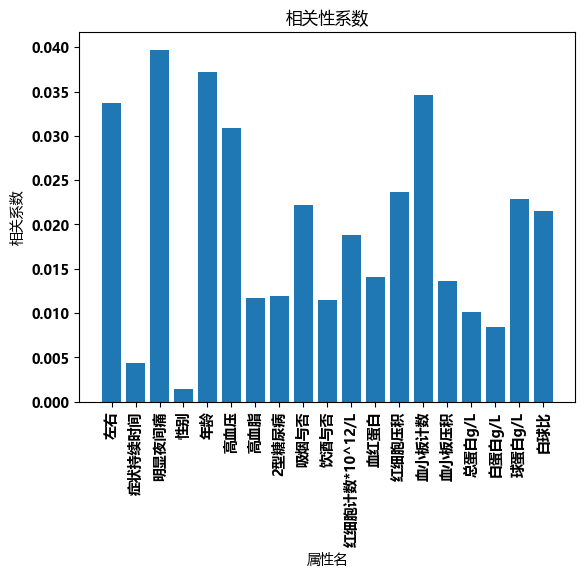

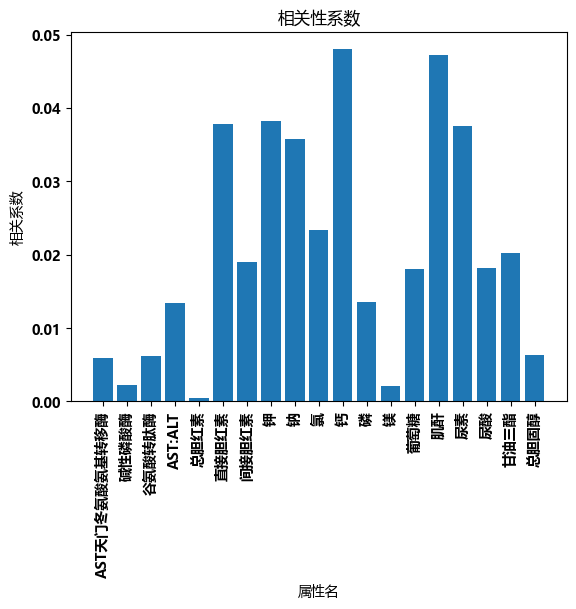

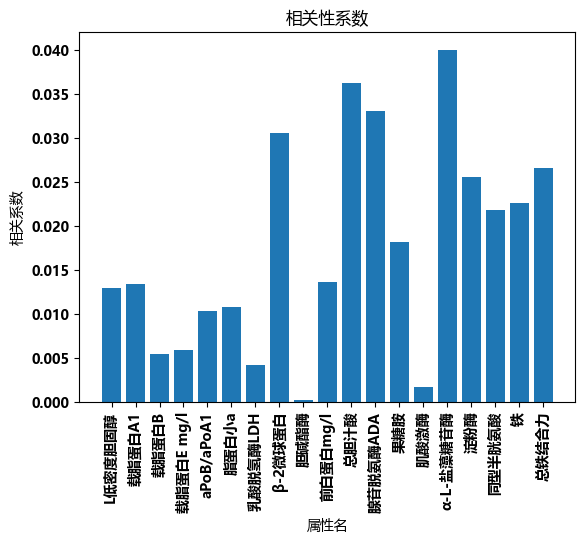

In [66]:
# 设置字体
set_font()
start = 0
end = 19
for i in range(3):
    # 使用自定义字体
    show_x = list(dict_.keys())[start:end]
    show_y = list(dict_.values())[start:end]
    plt.xlabel('属性名')
    plt.ylabel('相关系数')
    # 绘制柱状图
    plt.bar(show_x, show_y)
    # 显示图形
    start = start + 20
    end = end + 20
    plt.xticks(rotation=90)
    plt.title("相关性系数")
    plt.show()

### 使用决策树筛选特征

In [67]:
clf = tree.DecisionTreeClassifier(random_state=42)
clf = clf.fit(jibing.iloc[:,:-1],jibing.iloc[:,-1])

### 获取特征的重要性
#### 根据决策树的某些系数划分重要程度

In [68]:
tree_importance = clf.feature_importances_
tree_importance

array([0.        , 0.02326074, 0.00659053, 0.        , 0.        ,
       0.05460065, 0.01101743, 0.        , 0.        , 0.        ,
       0.        , 0.007203  , 0.01984946, 0.0198623 , 0.0256215 ,
       0.01070101, 0.01819517, 0.02124799, 0.01211059, 0.        ,
       0.00286817, 0.01352139, 0.00176079, 0.01056369, 0.0202138 ,
       0.00860452, 0.03524823, 0.0096046 , 0.01768036, 0.03691028,
       0.00179741, 0.01153643, 0.01594052, 0.        , 0.02540003,
       0.00931979, 0.01020756, 0.01320884, 0.0217657 , 0.02292562,
       0.02439664, 0.02102837, 0.03985822, 0.01436861, 0.02195428,
       0.02163025, 0.01065781, 0.03788594, 0.02641004, 0.02649717,
       0.00771241, 0.03196191, 0.01024707, 0.0275507 , 0.0026102 ,
       0.00813105, 0.0336205 , 0.03286545, 0.02745964, 0.02462667,
       0.00349828, 0.02569065])

### 由于特征是比较少的，所以将皮尔逊系数和决策树特征重要性放到一起考虑

In [69]:
# 确定一会儿要删除的特征
# 把它们放到drop_list中
drop_list = []

In [70]:
# 获取重要性为0的特征
indexes = [i for i, x in enumerate(tree_importance) if x == 0]

In [71]:
indexes

[0, 3, 4, 7, 8, 9, 10, 19, 33]

In [72]:
for index in indexes:
    if dict_[feature_ls[index]] < 0.01:
        drop_list.append(feature_ls[index])
drop_list

['性别', 'ALT丙氨酸氨基转移酶']

### 将无关属性去掉

In [73]:
jibing.shape

(1589, 63)

In [74]:
type(jibing)

pandas.core.frame.DataFrame

In [75]:
for name in drop_list:
    jibing.drop(name, axis=1,inplace = True)

In [76]:
jibing.shape

(1589, 61)

### 特征和结果分开

In [77]:
jibing_res = jibing.iloc[:,-1]
jibing_res.head()

0    1
1    0
2    1
3    0
4    0
Name: 结果, dtype: int64

In [78]:
jibing = jibing.iloc[:,:-1]
jibing.head()

,左右,是否外伤,症状持续时间,明显夜间痛,年龄,高血压,高血脂,2型糖尿病,吸烟与否,饮酒与否,...,腺苷脱氨酶ADA,果糖胺,肌酸激酶,α-L-盐藻糖苷酶,乳酸,淀粉酶,同型半胱氨酸,铁,总铁结合力,血型
0,1,0,3,1,62,1,0,0,0,0,...,9.0,2.12,135.0,24.0,1.5,55.0,10.8,35.5,49.7,3
1,0,0,3,0,54,0,0,0,1,0,...,8.0,1.96,60.0,32.0,1.8,71.0,13.5,15.7,58.5,3
2,1,1,3,0,70,1,0,0,1,1,...,12.0,1.82,123.0,26.0,3.1,60.0,13.3,9.1,52.8,0
3,1,0,4,1,60,0,0,0,1,1,...,10.0,2.10,93.0,30.0,1.6,46.0,18.6,23.1,56.5,0
4,1,1,3,0,76,1,0,0,0,0,...,13.0,2.44,82.0,19.0,1.8,95.0,16.5,19.0,50.8,3


In [79]:
jibing

,左右,是否外伤,症状持续时间,明显夜间痛,年龄,高血压,高血脂,2型糖尿病,吸烟与否,饮酒与否,...,腺苷脱氨酶ADA,果糖胺,肌酸激酶,α-L-盐藻糖苷酶,乳酸,淀粉酶,同型半胱氨酸,铁,总铁结合力,血型
0,1,0,3,1,62,1,0,0,0,0,...,9.0,2.12,135.0,24.0,1.50,55.0,10.8,35.5,49.7,3
1,0,0,3,0,54,0,0,0,1,0,...,8.0,1.96,60.0,32.0,1.80,71.0,13.5,15.7,58.5,3
2,1,1,3,0,70,1,0,0,1,1,...,12.0,1.82,123.0,26.0,3.10,60.0,13.3,9.1,52.8,0
3,1,0,4,1,60,0,0,0,1,1,...,10.0,2.10,93.0,30.0,1.60,46.0,18.6,23.1,56.5,0
4,1,1,3,0,76,1,0,0,0,0,...,13.0,2.44,82.0,19.0,1.80,95.0,16.5,19.0,50.8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,1,1,3,1,54,0,0,0,1,1,...,7.0,1.61,120.0,10.0,1.70,55.0,9.9,22.5,47.3,0
1585,0,1,4,1,63,0,0,0,0,0,...,12.0,2.06,227.0,27.0,1.50,83.0,9.7,9.7,39.4,2
1586,1,0,4,1,50,0,0,0,0,0,...,9.0,1.78,46.0,24.0,1.60,64.0,10.6,10.3,55.6,2
1587,1,0,3,1,64,0,0,0,0,0,...,12.0,2.21,73.0,17.0,1.50,75.0,9.0,17.1,58.8,2


### 保存

In [80]:
jibing.to_excel("./jibing_feature_final.xlsx", index=False)

In [81]:
jibing_res.to_excel("./jibing_feature_res_final.xlsx", index=False)

In [82]:
jibing

,左右,是否外伤,症状持续时间,明显夜间痛,年龄,高血压,高血脂,2型糖尿病,吸烟与否,饮酒与否,...,腺苷脱氨酶ADA,果糖胺,肌酸激酶,α-L-盐藻糖苷酶,乳酸,淀粉酶,同型半胱氨酸,铁,总铁结合力,血型
0,1,0,3,1,62,1,0,0,0,0,...,9.0,2.12,135.0,24.0,1.50,55.0,10.8,35.5,49.7,3
1,0,0,3,0,54,0,0,0,1,0,...,8.0,1.96,60.0,32.0,1.80,71.0,13.5,15.7,58.5,3
2,1,1,3,0,70,1,0,0,1,1,...,12.0,1.82,123.0,26.0,3.10,60.0,13.3,9.1,52.8,0
3,1,0,4,1,60,0,0,0,1,1,...,10.0,2.10,93.0,30.0,1.60,46.0,18.6,23.1,56.5,0
4,1,1,3,0,76,1,0,0,0,0,...,13.0,2.44,82.0,19.0,1.80,95.0,16.5,19.0,50.8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,1,1,3,1,54,0,0,0,1,1,...,7.0,1.61,120.0,10.0,1.70,55.0,9.9,22.5,47.3,0
1585,0,1,4,1,63,0,0,0,0,0,...,12.0,2.06,227.0,27.0,1.50,83.0,9.7,9.7,39.4,2
1586,1,0,4,1,50,0,0,0,0,0,...,9.0,1.78,46.0,24.0,1.60,64.0,10.6,10.3,55.6,2
1587,1,0,3,1,64,0,0,0,0,0,...,12.0,2.21,73.0,17.0,1.50,75.0,9.0,17.1,58.8,2


In [83]:
jibing_res

0       1
1       0
2       1
3       0
4       0
       ..
1584    1
1585    0
1586    0
1587    0
1588    0
Name: 结果, Length: 1589, dtype: int64